# Importing Data

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/refs/heads/main/data/US_macro_Quarterly.csv', index_col=0)

df.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [3]:
df.index = pd.to_datetime(df.index).to_period('Q')
df.index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', length=203)

In [4]:
df = df[['cpi']]
df.head()

,cpi
1959Q1,28.98
1959Q2,29.15
1959Q3,29.35
1959Q4,29.37
1960Q1,29.54


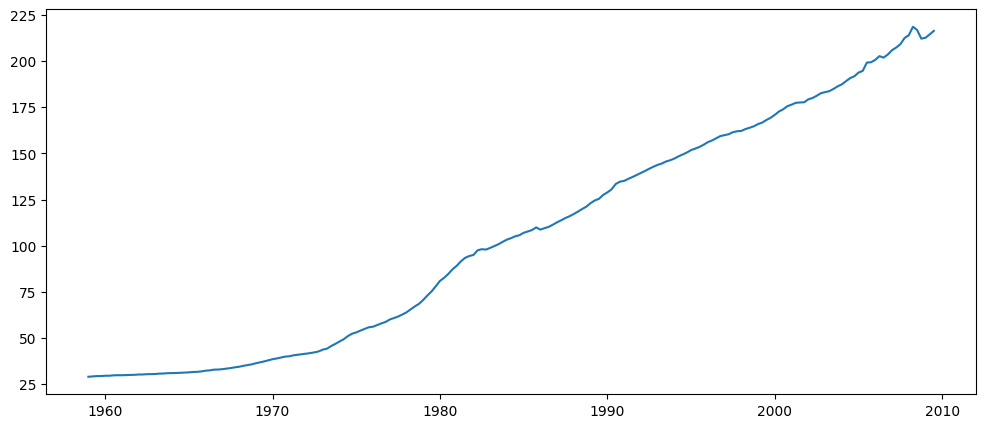

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index.to_timestamp(), df['cpi'])
plt.show()

Based on the graph I would select an ETS model with trend.

# Pycaret

In [6]:
from pycaret.time_series import *

In [7]:
exp = TSForecastingExperiment()
exp.setup(data = df, target='cpi', fh= 24)

,Description,Value
0,session_id,7068
1,Target,cpi
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(203, 1)"
5,Transformed data shape,"(203, 1)"
6,Transformed train set shape,"(179, 1)"
7,Transformed test set shape,"(24, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


1. In sample observations: 179
2. Hold out observations: 24

In [8]:
exp.plot_model(plot='train_test_split')

In [9]:
exp.plot_model(plot='decomp')

## Exponential Smoothing Methods

### SES Model

In [10]:
ses = exp.create_model('exp_smooth', trend=None, seasonal=None, sp=None, cross_validation=False)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,7.0101,6.6746,18.4940,20.9995,0.0887,0.0940,-3.4564


In [11]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error

def ts_metrics(y, y_hat):
    """
    Calculate and display time series evaluation metrics.
    
    Parameters:
    y (array-like): Actual values
    y_hat (array-like): Predicted values
    
    Returns:
    dict: A dictionary containing all calculated metrics
    """
    # Calculate metrics
    mae = mean_absolute_error(y, y_hat)
    mape = mean_absolute_percentage_error(y, y_hat)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    r2 = r2_score(y, y_hat)
    
    
    # Store metrics in a dictionary
    metrics = {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'R2': r2,
    }
    
    # Print metrics with descriptions
    print("Time Series Model Evaluation Metrics:")
    print("-" * 40)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4%}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    
    return

# in sample predictions
ses_y_pred = ses.predict(df.index[:-24])

ts_metrics(df['cpi'][:-24], ses_y_pred)

Time Series Model Evaluation Metrics:
----------------------------------------
Mean Absolute Error (MAE): 0.8870
Mean Absolute Percentage Error (MAPE): 1.0426%
Root Mean Squared Error (RMSE): 1.0888
R-squared (R²): 0.9996


In [12]:
# holdout predictions
ses_y_forecast = ses.predict(df.index[-24:])

ts_metrics(df['cpi'][-24:], ses_y_forecast)

Time Series Model Evaluation Metrics:
----------------------------------------
Mean Absolute Error (MAE): 18.4940
Mean Absolute Percentage Error (MAPE): 8.8725%
Root Mean Squared Error (RMSE): 20.9995
R-squared (R²): -3.4564


### Holt's linear

In [13]:
ht = exp.create_model('exp_smooth', trend='add', seasonal=None, cross_validation=False)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.6604,2.5729,7.0187,8.0947,0.0337,0.0344,0.3378


In [14]:
# in sample predictions
ht_y_pred = ht.predict(df.index[:-24])

ts_metrics(df['cpi'][:-24], ht_y_pred)

Time Series Model Evaluation Metrics:
----------------------------------------
Mean Absolute Error (MAE): 0.2948
Mean Absolute Percentage Error (MAPE): 0.3433%
Root Mean Squared Error (RMSE): 0.4448
R-squared (R²): 0.9999


In [15]:
# hold out predictions
ht_y_forecast = ht.predict(df.index[-24:])

ts_metrics(df['cpi'][-24:], ht_y_forecast)

Time Series Model Evaluation Metrics:
----------------------------------------
Mean Absolute Error (MAE): 7.0187
Mean Absolute Percentage Error (MAPE): 3.3678%
Root Mean Squared Error (RMSE): 8.0947
R-squared (R²): 0.3378


### Holt's Winter with Additive

In [16]:
hw_add = exp.create_model('exp_smooth', trend='add', seasonal='add', sp= 12, cross_validation=False)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.7549,2.6535,7.2678,8.3485,0.0349,0.0357,0.2957


In [17]:
# in sample predictions
ht_add_y_pred = hw_add.predict(df.index[:-24])

ts_metrics(df['cpi'][:-24], ht_add_y_pred)

Time Series Model Evaluation Metrics:
----------------------------------------
Mean Absolute Error (MAE): 0.2975
Mean Absolute Percentage Error (MAPE): 0.3646%
Root Mean Squared Error (RMSE): 0.4322
R-squared (R²): 0.9999


In [18]:
# hold out predictions
ht_add_y_forecast = hw_add.predict(df.index[-24:])

ts_metrics(df['cpi'][-24:], ht_add_y_forecast)

Time Series Model Evaluation Metrics:
----------------------------------------
Mean Absolute Error (MAE): 7.2678
Mean Absolute Percentage Error (MAPE): 3.4884%
Root Mean Squared Error (RMSE): 8.3485
R-squared (R²): 0.2957


### Holt's Winter with Multiplicative

In [19]:
hw_mult = exp.create_model('exp_smooth', trend='add', seasonal='mul', sp=12, cross_validation=False)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.8408,2.7253,7.4945,8.5742,0.0360,0.0368,0.2571


In [20]:
# in sample predictions
ht_mult_y_pred = hw_mult.predict(df.index[:-24])

ts_metrics(df['cpi'][:-24], ht_mult_y_pred)

Time Series Model Evaluation Metrics:
----------------------------------------
Mean Absolute Error (MAE): 0.2893
Mean Absolute Percentage Error (MAPE): 0.3445%
Root Mean Squared Error (RMSE): 0.4244
R-squared (R²): 0.9999


In [21]:
# hold out predictions
ht_mult_y_forecast = hw_mult.predict(df.index[-24:])

ts_metrics(df['cpi'][-24:], ht_mult_y_forecast)

Time Series Model Evaluation Metrics:
----------------------------------------
Mean Absolute Error (MAE): 7.4945
Mean Absolute Percentage Error (MAPE): 3.5991%
Root Mean Squared Error (RMSE): 8.5742
R-squared (R²): 0.2571


The Holt's linear methods all had the same in sample R-squared. 

The model that had the highest hold-out set R-squared was the Holt's Linear

### Comparing the models

In [22]:
exp.plot_model(estimator=[ses, ht, hw_add, hw_mult], plot='residuals', 
               data_kwargs={'labels':["SES", "Holt Linear", "Holt-Winter-Add",'Holt-Winter-Mult']})

In [23]:
exp.plot_model(estimator=[ses, ht, hw_add, hw_mult], plot='forecast', 
               data_kwargs={'fh':36,
                            'labels':["SES", "Holt Linear", "Holt-Winter-Add",'Holt-Winter-Mult']})

In [24]:
exp.compare_models(include=[ses, ht, hw_add, hw_mult])

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
2,Exponential Smoothing,0.7746,0.7630,1.8368,2.3310,0.0130,0.0132,0.8919,0.7067
3,Exponential Smoothing,0.7767,0.7587,1.8357,2.3158,0.0131,0.0133,0.8937,0.7033
1,Exponential Smoothing,0.7823,0.7762,1.8604,2.3748,0.0130,0.0132,0.8927,0.6800
0,Exponential Smoothing,5.1972,4.8216,12.6986,14.9762,0.0849,0.0903,-2.6703,1.1367


ExponentialSmoothing(seasonal='add', sp=12, trend='add')

Based on the comparison the Holts Winter Additive is performing the best.

In [25]:
naive = exp.create_model('naive', cross_validation=False)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,7.0101,6.6746,18.4940,20.9995,0.0887,0.0940,-3.4564


In [26]:
exp.compare_models(include=[naive, hw_add])

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
1,Exponential Smoothing,0.7746,0.7630,1.8368,2.3310,0.0130,0.0132,0.8919,0.6900
0,Naive Forecaster,5.1972,4.8216,12.6986,14.9762,0.0849,0.0903,-2.6703,0.6700


ExponentialSmoothing(seasonal='add', sp=12, trend='add')

Based on the comparison to the naive model the Holts winter additive is outperforming the Naive forecaster. 

## ETS Models

In [27]:
ets_ANN = exp.create_model('ets', error="add", trend=None, seasonal=None ,cross_validation=False )

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,7.0102,6.6746,18.4941,20.9996,0.0887,0.0940,-3.4565


The holdout MAPE is 8.87% and we can interpret that by saying on average the predictions deviate by 8.87% from the actual values. 

In [28]:
ets_AAN = exp.create_model('ets', error="add", trend="add", seasonal=None ,cross_validation=False )

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.6604,2.5729,7.0187,8.0947,0.0337,0.0344,0.3378


The holdout RMSE is 8.0947 and the units are in the same format as the target variable CPI

In [29]:
ets_AAM = exp.create_model('ets', error="add", trend="add", seasonal="mul" ,cross_validation=False )

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.8143,2.7095,7.4246,8.5244,0.0356,0.0365,0.2657


The holdout sMAPE is 3.65% and it stands for symmetric mean absolute percentage error. The difference between MAPE and sMAPE is that sMAPE treats overestimation and underestimation the same. 

In [30]:
exp.compare_models(include=[ets_ANN, ets_AAN, ets_AAM, naive])

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
2,ETS,0.7292,0.7142,1.7378,2.1878,0.0122,0.0123,0.9133,0.6800
1,ETS,0.7823,0.7763,1.8604,2.3749,0.0130,0.0132,0.8927,0.6700
0,ETS,5.1972,4.8216,12.6987,14.9763,0.0849,0.0903,-2.6703,1.1567
3,Naive Forecaster,5.1972,4.8216,12.6986,14.9762,0.0849,0.0903,-2.6703,0.6533


AutoETS(seasonal='mul', sp=3, trend='add')

The winning model is ets_AAM

In [35]:
exp.plot_model(estimator=[ets_ANN, ets_AAN, ets_AAM, naive], 
               data_kwargs={'fh':36,
                            'labels':['ANN','AAN','AAM','naive']})

ANN and AAM are basically overlapping

In [37]:
predictions = exp.predict_model(ets_AAM)
predictions

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ETS,2.8143,2.7095,7.4246,8.5244,0.0356,0.0365,0.2657


,y_pred
2003Q4,185.6263
2004Q1,186.6106
2004Q2,187.5577
2004Q3,188.3026
2004Q4,189.2883
2005Q1,190.2361
2005Q2,190.9789
2005Q3,191.9659
2005Q4,192.9146
2006Q1,193.6552


The prediction for 2009Q3 is 206.3067

In [38]:
final_model = exp.finalize_model(ets_AAM)

In [46]:
unseen_predictions = exp.predict_model(final_model, fh=64)
period_2023Q1 = pd.Period('2023Q1', freq='Q')
value = unseen_predictions.loc[period_2023Q1, 'y_pred']
print(value)

269.3301


The final forecast for 2023Q1 is 269.3301